# Mini-GPT desde cero en Google Colab

"""
Este notebook implementa un modelo GPT en miniatura desde cero con PyTorch.
La idea es entender y experimentar con los conceptos básicos de atención,
tokenización, y generación de texto sin necesidad de una gran computadora.
"""

In [21]:
# Paso 1: Instalación de dependencias
!pip install torch matplotlib --quiet

In [22]:
# Paso 2: Imports iniciales
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict

In [45]:
# Paso 3: Dataset pequeño de ejemplo (versión por palabras)
texto = """
La luna se asoma detrás del monte,
como un ojo que espía el silencio.
El viento arrastra hojas secas,
dibujando círculos en el aire.

La noche canta con voz de agua,
y las estrellas tiemblan en su lecho.
Un farol parpadea en la distancia,
como un suspiro que no quiere irse.

Bajo un cielo bordado de sombra,
las palabras se ocultan en el pecho.
Todo calla, todo espera,
como si el mundo respirara lento.

Los árboles murmuran viejas historias,
y el río sueña con su nacimiento.
Una flor se abre en plena oscuridad,
y el universo guarda el secreto.
"""

In [46]:
# Paso 4: Tokenización por palabras con soporte para <unk>
palabras = texto.lower().replace("\n", " ").split()
vocab = sorted(set(palabras + ["<unk>"]))  # agregamos token desconocido
vocab_size = len(vocab)
stoi = { w:i for i,w in enumerate(vocab) }
itos = { i:w for i,w in enumerate(vocab) }

# encode usa <unk> si la palabra no existe en el vocabulario
encode = lambda s: [stoi.get(w, stoi["<unk>"]) for w in s.lower().replace("\n", " ").split()]
decode = lambda l: ' '.join([itos[i] for i in l])

data = torch.tensor(encode(texto), dtype=torch.long)

In [57]:
# Paso 5: Hiperparámetros
BLOCK_SIZE = 6  # menos contexto, porque usamos palabras
BATCH_SIZE = 4
EMBED_DIM = 32
N_HEADS = 2
N_LAYERS = 2
EPOCHS = 300
LEARNING_RATE = 1e-3

In [58]:
# Paso 6: Batching
def get_batch(data):
    ix = torch.randint(len(data) - BLOCK_SIZE, (BATCH_SIZE,))
    x = torch.stack([data[i:i+BLOCK_SIZE] for i in ix])
    y = torch.stack([data[i+1:i+BLOCK_SIZE+1] for i in ix])
    return x, y


In [59]:
# Paso 7: Modelo MiniGPT
class SelfAttentionHead(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(EMBED_DIM, head_size, bias=False)
        self.query = nn.Linear(EMBED_DIM, head_size, bias=False)
        self.value = nn.Linear(EMBED_DIM, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(BLOCK_SIZE, BLOCK_SIZE)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) / (C**0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, EMBED_DIM)

    def forward(self, x):
        return self.proj(torch.cat([h(x) for h in self.heads], dim=-1))

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(EMBED_DIM, 4 * EMBED_DIM),
            nn.ReLU(),
            nn.Linear(4 * EMBED_DIM, EMBED_DIM),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = MultiHeadAttention(N_HEADS, EMBED_DIM // N_HEADS)
        self.ffwd = FeedForward()
        self.ln1 = nn.LayerNorm(EMBED_DIM)
        self.ln2 = nn.LayerNorm(EMBED_DIM)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class MiniGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, EMBED_DIM)
        self.pos_emb = nn.Embedding(BLOCK_SIZE, EMBED_DIM)
        self.blocks = nn.Sequential(*[Block() for _ in range(N_LAYERS)])
        self.ln_f = nn.LayerNorm(EMBED_DIM)
        self.head = nn.Linear(EMBED_DIM, vocab_size)

    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos_emb = self.pos_emb(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -BLOCK_SIZE:]
            logits = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx

# Crear modelo y optimizador
model = MiniGPT()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)


In [60]:
# Paso 8: Entrenamiento con registro de pérdida
losses = []
for step in range(EPOCHS):
    x, y = get_batch(data)
    logits = model(x)
    loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Paso {step} - Pérdida: {loss.item():.4f}")

Paso 0 - Pérdida: 4.4174
Paso 50 - Pérdida: 3.7569
Paso 100 - Pérdida: 2.6871
Paso 150 - Pérdida: 1.8898
Paso 200 - Pérdida: 1.0408
Paso 250 - Pérdida: 0.7056


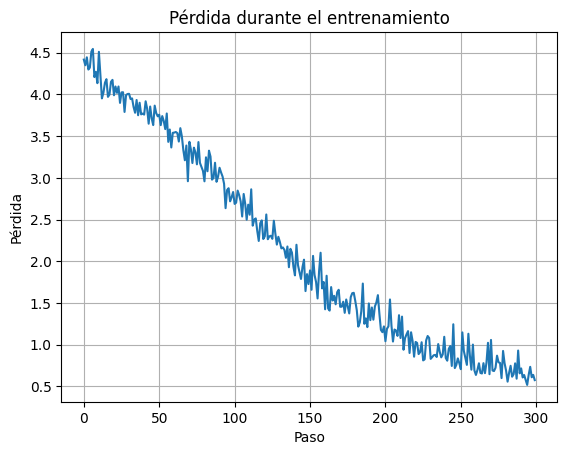

In [61]:
# Paso 9: Graficar pérdida de entrenamiento
plt.plot(losses)
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Paso")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()

In [62]:
# Paso 10: Guardar modelo
PATH = "minigpt_model.pt"
torch.save(model.state_dict(), PATH)
print("Modelo guardado en minigpt_model.pt")

Modelo guardado en minigpt_model.pt


In [53]:
# Paso 11: Cargar modelo (opcional)
# model.load_state_dict(torch.load(PATH))
# print("Modelo cargado desde disco")

In [63]:
# Paso 12: Interfaz interactiva para generación en Colab
print("Consultá al modelo ingresando algunas palabras:")
entrada = input(f"Ingrese un inicio de frase (máx {BLOCK_SIZE} palabras): ")
contexto = encode(entrada.strip())
context_tensor = torch.tensor([contexto], dtype=torch.long)
salida = model.generate(context_tensor, 10)[0].tolist()
print("--- Texto generado ---")
print(decode(salida))

Consultá al modelo ingresando algunas palabras:
Ingrese un inicio de frase (máx 6 palabras): noche
--- Texto generado ---
noche su lecho. un farol parpadea las si en la árboles
